## Задание 1

[kaggle task](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

Есть датасет с характеристиками покупателей в магазине.
<br>
Требуется разбить покупателей на k кластеров (выбор k остается за тобой), посчитать силуэт и визуализировать полученные кластеры

Выбор k должен быть обоснован, применять можно абсолютно любые алгоритмы.

**Заметка**: можно генерировать новые признаки и/или не использовать все имеющиеся, да и вообще делать все, что угодно и не противоречит здравому смыслу :)

**Не забывай фиксировать random_state для воспроизводимости результатов, где это требуется**

In [309]:
!pip install MulticoreTSNE

In [310]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from pathlib import Path

##other libraries on need##

In [311]:
df = pd.read_csv(Path('..', 'data', 'mall_customers.csv'))
print(df.shape)
df.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94919f79e8>,
      dtype=object)

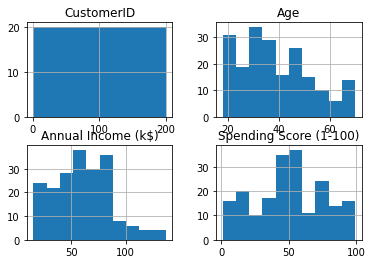

In [312]:
df.hist()
#Видим, что данные не имеют нормальное распределение, поэтому не будем приводить их у нулевому 
#матожиданию и единичной дисперсии(маловато данных)

In [313]:
df.info()
#нет пропусков в данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [314]:
from sklearn.preprocessing import StandardScaler
df = df.set_index('CustomerID')
df['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)
#Установbм CustomerID как индекс, и преобразуем Gender 

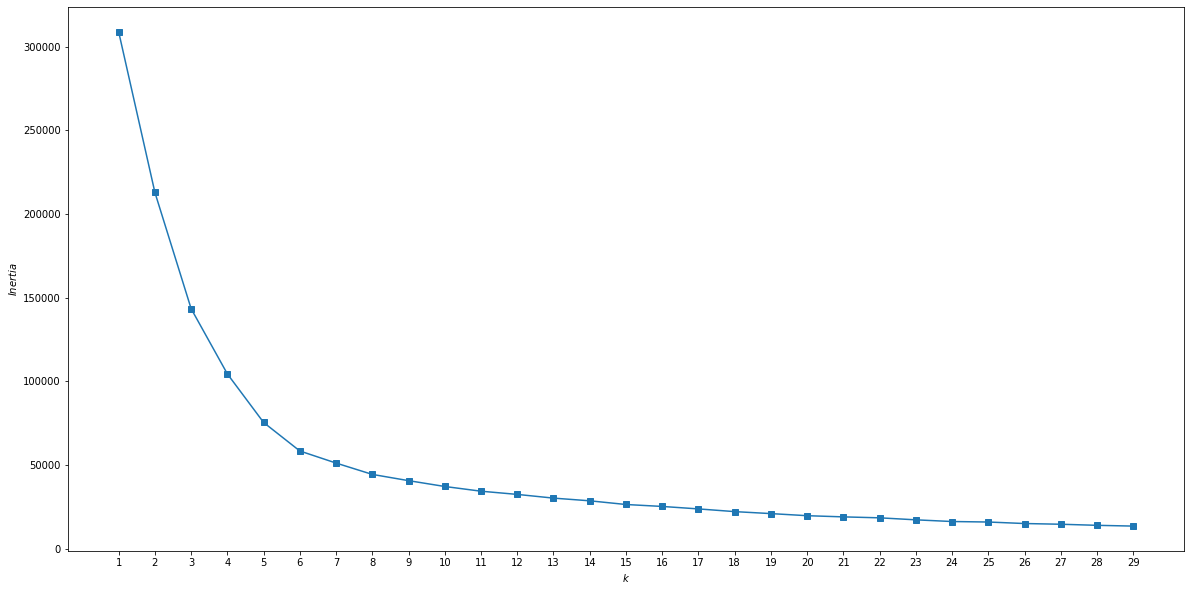

In [315]:
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df)
    inertia.append(kmeans.inertia_)

    
plt.figure(figsize=(20,10))
plt.plot(range(1, 30), inertia, marker='s');
plt.xticks(range(1,30))
plt.xlabel('$k$')
plt.ylabel('$Inertia$');
#Из графика видно, что 6 оптимальный вариант


In [316]:
tSNE = TSNE(n_components = 2, random_state = 42, metric='euclidean', n_jobs=-1)
df_transform =tSNE.fit_transform(df);
#Для визуализации понизим размерность

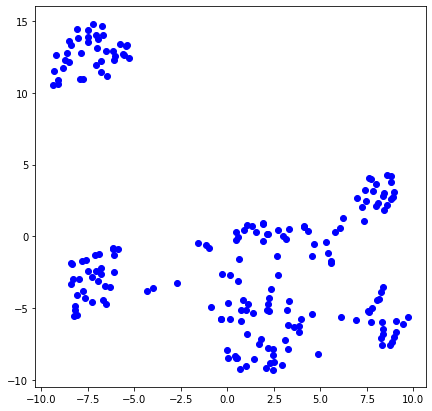

In [346]:
#plot data
plt.figure(figsize=(7, 7))
plt.scatter(df_transform[:, 0], df_transform[:, 1], c='blue');

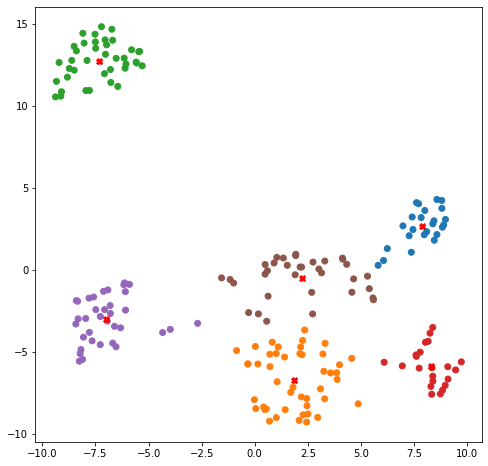

In [347]:
kmeans = KMeans(n_clusters=6,random_state =42, n_jobs=-1).fit(df_transform)
yhat_kmeans = kmeans.predict(df_transform) #=kmeans.labels_

colors = ['#1f77b4' if x==0 else '#ff7f0e' if x==1 else '#2ca02c' if x==2 else '#d62728' if x==3 else '#9467bd' if x==4 else '#8c564b' for x in yhat_kmeans]

plt.figure(figsize=(8,8))
for i in range(kmeans.cluster_centers_.shape[0]):
    plt.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], 'rX')
plt.scatter(df_transform[:,0], df_transform[:,1], c=colors, picker=True);

In [350]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

#metrics
from sklearn.metrics import silhouette_score
def hopkins_statistics(X):
    n, d = X.shape[0], X.shape[1]
    m = int(0.1 * n) # heuristic from article
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(n), m)
 
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0), np.amax(X,axis=0), d).reshape(1, -1)
                                    , 2, return_distance=True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(wjd) / (sum(ujd) + sum(wjd))
    
    return H
print(f'Hopkins statistics: {hopkins_statistics(df_transform)}')
#Наши преобразованные данные имеют неплохую кластерную структуру


Hopkins statistics: 0.13134554092043932


In [351]:
kmeans = KMeans(n_clusters=6,random_state =42, n_jobs=-1).fit(df)
yhat_kmeans = kmeans.predict(df) 

In [352]:
print(f'Silhouette score K-means: {silhouette_score(df, yhat_kmeans)}')

Silhouette score K-means: 0.3892133361537402


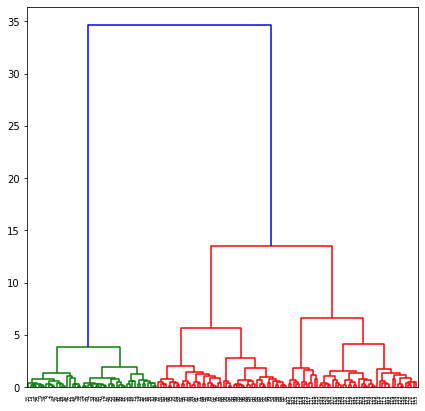

In [353]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram
    create the counts of samples under each node
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
agclust = AgglomerativeClustering(n_clusters=None, distance_threshold=1).fit(df)
plt.figure(figsize=(7, 7))
plot_dendrogram(agclust)

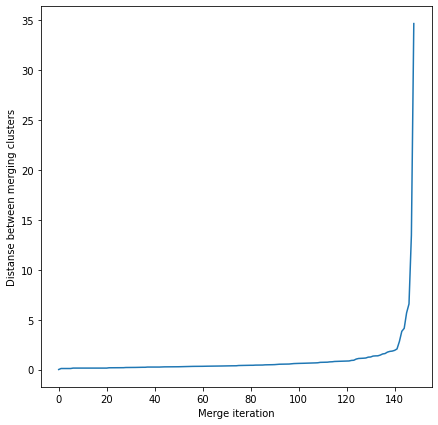

In [354]:
plt.figure(figsize=(7,7))
plt.ylabel('Distanse between merging clusters')
plt.xlabel('Merge iteration')
plt.plot(list(range(len(agclust.distances_))), agclust.distances_);

In [355]:
num_clus = 6
agclust = AgglomerativeClustering(n_clusters=num_clus, distance_threshold=None).fit(df)
yhat_agclust = agclust.labels_

In [356]:
print(f'Silhouette score agglomerative clustering: {silhouette_score(df, yhat_agclust)}')

Silhouette score agglomerative clustering: 0.5145245423357022


## Задание 2 (по желанию)

Возьмем стандартный датасет ирисов, состоящий из 4-х признаков длины/ширины внутренней и наружной долей околоцветника и таргета - вид цветка (kind).

1.Требуется кластеризовать цветки (да-да, количество кластеров уже известно), посчитать **accuracy**. Выбор алгоритма опять же на усмотрение (может быть несколько)
<br>
**Важно**: метки могут расставиться в другом порядке относительно истинного таргета, то есть после кластеризации будут получены 0, а это на самом деле 1, то есть надо сделать отображение $0 \rightarrow 1$ , то же самое касается и других меток. 
<br>
Поэтому, получив метки кластеров, стоит перебрать все возможные их перестановки. В этом поможет itertools.permutations

2.Воспользоваться любым/любыми пройденными/известными алгоритмами классификации и посчитать **accuracy** 
<br>
(Например, логистической регрессией)

In [357]:
from sklearn import datasets
import itertools

##other libraries on need##

In [358]:
df = datasets.load_iris()
df = pd.DataFrame(np.hstack([df['data'], df['target'].reshape(-1,1)])
             , columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'kind'])

print('Count of unique flowers', df['kind'].unique().shape[0])
df.head()

Count of unique flowers 3


,sepal_length,sepal_width,petal_length,petal_width,kind
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Кластеризация

In [359]:
def validate_with_mappings(y_true, y_pred):
    '''
    Check all possible permutations to maximize accuracy
    '''
    
    l = []
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {0 : a, 1: b, 2: c}
        mapped_preds = [mapping[pred] for pred in y_pred]
        l.append((mapping, sum(mapped_preds == y_true) / len(y_true)))
                 
    return l

In [361]:
X = df.iloc[:, :-1]
y = df['kind']

kmeans = KMeans(n_clusters=3,random_state =42, n_jobs=-1).fit(X)
yhat_kmeans = kmeans.predict(X)
validate_with_mappings(y,yhat_kmeans)

[({0: 0, 1: 1, 2: 2}, 0.24),
 ({0: 0, 1: 2, 2: 1}, 0.013333333333333334),
 ({0: 1, 1: 0, 2: 2}, 0.8933333333333333),
 ({0: 1, 1: 2, 2: 0}, 0.32),
 ({0: 2, 1: 0, 2: 1}, 0.44),
 ({0: 2, 1: 1, 2: 0}, 0.09333333333333334)]

### Классификация

In [362]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(random_state=42).fit(X, y)
print(accuracy_score(y,clf.predict(X)))


0.9733333333333334


**Вопрос**: что оказалось лучше: алгоритм классификации или кластеризации и на сколько?
<br>
**Ответ**: ****

In [363]:
#Лучше оказался алгоритм классификации, на 0.07

In [364]:
tSNE = TSNE(n_components = 2, random_state = 42, metric='euclidean', n_jobs=-1)
df_transform1 =tSNE.fit_transform(X);

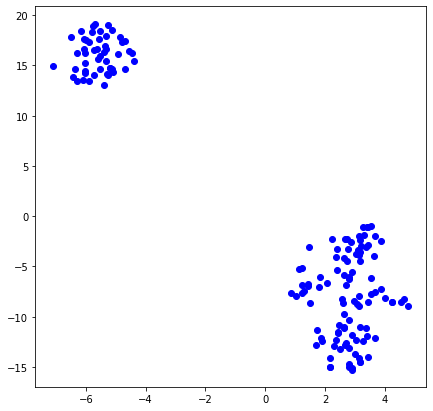

In [365]:
plt.figure(figsize=(7, 7))
plt.scatter(df_transform1[:, 0], df_transform1[:, 1], c='blue');

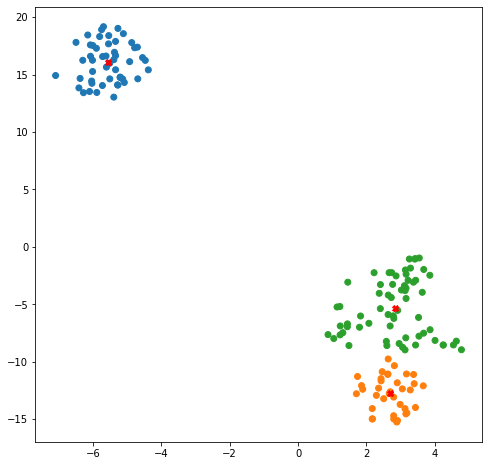

In [366]:
kmeans = KMeans(n_clusters=3,random_state =42, n_jobs=-1).fit(df_transform1)
#predict
yhat_kmeans = kmeans.predict(df_transform1) #=kmeans.labels_

#plot
colors = ['#1f77b4' if x==0 else '#ff7f0e' if x==1 else '#2ca02c' if x==2 else '#d62728' if x==3 else '#9467bd' if x==4 else '#8c564b' for x in yhat_kmeans]
#['c' if x==0 else 'b' if x==1 else 'g' if x==2 ''else 'black' for x in yhat_kmeans]

plt.figure(figsize=(8,8))
for i in range(kmeans.cluster_centers_.shape[0]):
    plt.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], 'rX')
plt.scatter(df_transform1[:,0], df_transform1[:,1], c=colors, picker=True);

In [369]:
#Видим, что один класс линейно разделим от остальных и данные имеют отличную кластерную структуру

In [370]:
print(f'Hopkins statistics: {hopkins_statistics(df_transform1)}')

Hopkins statistics: 0.06492119022533528
